In [2]:
import os


In [1]:
import torch
import torch.nn as nn
import os
import  numpy as np
import scipy.io
from PIL import  Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchsummary import summary
import math
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

In [6]:
path_images = 'D:/Coding_folder/Vision_Transformer/Dataset/airplanes'
path_annot = 'D:/Coding_folder/Vision_Transformer/Dataset/Airplanes_Side_2'


In [7]:
# List of paths to images and annotations
image_paths = []
annot_paths = []

# Walk through the directory structure to find image and annotation paths
for root, dirs, files in os.walk(path_images):
    for file in files:
        if file.endswith(".jpg"):  # Assuming images are jpg files
            image_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(path_annot):
    for file in files:
        if file.endswith(".mat"):  # Assuming annotations are txt files
            annot_paths.append(os.path.join(root, file))

# Sort paths for consistency
image_paths.sort()
annot_paths.sort()

In [8]:
image_size = 224

images = []
targets = []

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Load and preprocess images
for i in range(len(annot_paths)):
    annot = scipy.io.loadmat(annot_paths[i])["box_coord"][0]
    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = Image.open(image_paths[i])
    (w, h) = image.size[:2]

    # Apply transformations
    image = transform(image)

    # Append image tensor to list
    images.append(image)

    # Apply relative scaling to bounding boxes
    target = torch.tensor([
        float(top_left_x) / w,
        float(top_left_y) / h,
        float(bottom_right_x) / w,
        float(bottom_right_y) / h,
    ])
    targets.append(target)

In [9]:
# Convert lists to PyTorch tensors
x_train = torch.stack(images[:int(len(images) * 0.8)])
y_train = torch.stack(targets[:int(len(targets) * 0.8)])

x_test = torch.stack(images[int(len(images) * 0.2):])
y_test = torch.stack(targets[int(len(targets) * 0.8):])

In [10]:
print(len(x_train))
print(len(y_train))

640
640


In [11]:
class projection_layer(nn.Module):
    def __init__(self,projection_dim:int,hidden_unit:int,dropout:float) -> None:
        super().__init__()
        self.hidden_units=hidden_unit
        self.projection_dim=projection_dim
        self.Drop_out=nn.Dropout(dropout)
        self.linear1=nn.Linear(projection_dim,hidden_unit[0])
        self.linear2=nn.Linear(hidden_unit[0],hidden_unit[1])

    def forward(self,x):
        out1=self.linear1(x)
        out2=self.Drop_out(out1)
        out3=self.linear2(out2)
        out4=self.Drop_out(out3)
        return out4


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
print(device)

cuda


In [14]:
class PatchEncoder(nn.Module):
    def __init__(self, patch_size:int,input_size:int,projection_dim:int,num_patches:int):
        super().__init__()
        self.input_size=input_size[1]
        self.projection_layer=nn.Linear((3*patch_size*patch_size),projection_dim)
        self.postion_embedding=nn.Embedding(num_patches,projection_dim)
        self.patch_size=patch_size
        self.num_patches=num_patches

    def forward(self, images):
        positions = torch.unsqueeze(torch.arange(0, self.num_patches, 1), dim=0)
        positions = positions.to(device)
        batch_size, channels, height, width = images.size()
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size,num_patches_h * num_patches_w,self.patch_size *self.patch_size * channels)
        patches = patches.permute(0,1,2)
        out=self.projection_layer(patches)
        encoded=out+self.postion_embedding(positions)
        return encoded


    def extra_repr(self):
        return 'patch_size={}'.format(self.patch_size)

In [15]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * (x - mean) / torch.sqrt(std + self.eps) + self.bias

In [16]:
class residualconnections(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self,x,sublayer):
        x=x+(sublayer(x))
        return x

In [17]:
class MultiHeadAttenionBlock(nn.Module):
    def __init__(self,projection_dim:int,dropout:float,num_heads:int):
        super().__init__()
        self.num_heads=num_heads
        self.projection_dim=projection_dim


        self.d_k=projection_dim//num_heads
        self.w_q=nn.Linear(projection_dim,projection_dim)
        self.w_k=nn.Linear(projection_dim,projection_dim)
        self.w_v=nn.Linear(projection_dim,projection_dim)

        self.w_o=nn.Linear(projection_dim,projection_dim)
        self.dropout=nn.Dropout(dropout)


    def attenion(key,query,value,dropout:nn.Dropout):
        d_k=query.shape[-1]
        attenion_score=(query@key.transpose(-2,-1))/math.sqrt(d_k)
        attenion_score=attenion_score.softmax(dim=-1)
        attenion_score=dropout(attenion_score)
        return  (attenion_score@value),attenion_score


    def forward(self,q,k,v):
        query=self.w_k(q)
        key=self.w_q(k)
        value=self.w_v(v)


        query=query.view(query.shape[0],query.shape[1],self.num_heads,self.d_k).transpose(1,2)
        key=key.view(key.shape[0],key.shape[1],self.num_heads,self.d_k).transpose(1,2)
        value=value.view(value.shape[0],value.shape[1],self.num_heads,self.d_k).transpose(1,2)



        x,self.attenion_score=MultiHeadAttenionBlock.attenion(key,query,value,self.dropout)

        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.num_heads*self.d_k)

        return self.w_o(x)

In [18]:
class  TransformerBlock(nn.Module):

    def __init__(self,self_attention_block:MultiHeadAttenionBlock,dropout:float,hidden_units:int,projection_dim:int,layer_normalization:LayerNormalization,projection_layer1=projection_layer):
        super().__init__()
        self.layer_normalization=LayerNormalization()
        self.self_attention_block=self_attention_block
        self.residual_connections=nn.ModuleList([residualconnections() for _ in range(2)])
        self.drop_out=dropout
        self.hidden_units=hidden_units
        self.projection_dim=projection_dim
        self.projection_layer=projection_layer1

    def forward(self,x):
        x=self.layer_normalization(x)
        x=self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x))
        x=self.layer_normalization(x)
        x=self.residual_connections[1](x,lambda x:self.projection_layer(x))

        return x

In [19]:
class mlp(nn.Module):
    def __init__(self,projection_dim:int,mlp_units:int,drop_out:float,num_p:int):
        super().__init__()
        self.projection_dim=projection_dim
        self.num_p=num_p
        self.mlp_unit=mlp_units
        self.Drop_out=nn.Dropout(drop_out)
        self.linear1=nn.Linear(self.projection_dim*self.num_p,mlp_units[0])
        self.linear2=nn.Linear(mlp_units[0],mlp_units[1])
        self.linear3=nn.Linear(mlp_units[1],mlp_units[2])
        self.linear4=nn.Linear(mlp_units[2],mlp_units[3])
        self.linear5=nn.Linear(mlp_units[3],mlp_units[4])
        self.linear6=nn.Linear(mlp_units[4],4)

    def forward(self,x):
        out1=self.linear1(x)
        out2=self.Drop_out(out1)
        out3=self.linear2(out2)
        out4=self.Drop_out(out3)
        out5=self.linear3(out4)
        out6=self.Drop_out(out5)
        out7=self.linear4(out6)
        out8=self.Drop_out(out7)
        out9=self.linear5(out8)
        out10=self.Drop_out(out9)
        out11=self.linear6(out10)
        return out11

In [20]:
class Bounding_box(nn.Module):
    def __init__(self,drop_out:float,layer_normalization:LayerNormalization,mlp1=mlp) -> None:
        super().__init__()
        self.drop_out_layer=nn.Dropout(drop_out)
        self.layer_normalization=LayerNormalization()
        self.mlp1=mlp1
    def forward(self,x):
        x=self.layer_normalization(x)
        x=self.drop_out_layer(torch.flatten(x,start_dim=1))
        x=self.mlp1(x)
        return x

In [21]:
class VITdetector(nn.Module):
    def __init__(self,layers:nn.ModuleList) -> None:
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalization()

    def forward(self,x):
        for layer in self.layers:
            x=layer(x)
        return (x)

In [22]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    vit=[]
    encoded_patches=PatchEncoder(patch_size,input_shape,projection_dim,num_patches)
    vit.append(encoded_patches)
    for i in range(transformer_layers):
        self_attention=MultiHeadAttenionBlock(projection_dim,0.1,num_heads)
        p_layer=projection_layer(projection_dim,transformer_units,0.3)
        Transformer_block=TransformerBlock(self_attention,0.1,transformer_units,projection_dim,LayerNormalization(),p_layer)
        vit.append(Transformer_block)
    mlp1=mlp(projection_dim,mlp_head_units,0.3,num_patches)
    bounding_box=Bounding_box(0.3,LayerNormalization(),mlp1)
    vit.append(bounding_box)


    vit_module=nn.ModuleList(vit)

    return vit_module

In [23]:
image_size=224
patch_size=32
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]

In [24]:
model_layer_list = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

In [25]:
model=VITdetector(model_layer_list)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VITdetector(
  (layers): ModuleList(
    (0): PatchEncoder(
      patch_size=32
      (projection_layer): Linear(in_features=3072, out_features=64, bias=True)
      (postion_embedding): Embedding(49, 64)
    )
    (1-4): 4 x TransformerBlock(
      (layer_normalization): LayerNormalization()
      (self_attention_block): MultiHeadAttenionBlock(
        (w_q): Linear(in_features=64, out_features=64, bias=True)
        (w_k): Linear(in_features=64, out_features=64, bias=True)
        (w_v): Linear(in_features=64, out_features=64, bias=True)
        (w_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (residual_connections): ModuleList(
        (0-1): 2 x residualconnections()
      )
      (projection_layer): projection_layer(
        (Drop_out): Dropout(p=0.3, inplace=False)
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
     

In [27]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 49, 64]         196,672
         Embedding-2               [-1, 49, 64]           3,136
      PatchEncoder-3               [-1, 49, 64]               0
LayerNormalization-4               [-1, 49, 64]               1
            Linear-5               [-1, 49, 64]           4,160
            Linear-6               [-1, 49, 64]           4,160
            Linear-7               [-1, 49, 64]           4,160
           Dropout-8            [-1, 4, 49, 49]               0
            Linear-9               [-1, 49, 64]           4,160
MultiHeadAttenionBlock-10               [-1, 49, 64]               0
residualconnections-11               [-1, 49, 64]               0
LayerNormalization-12               [-1, 49, 64]               1
           Linear-13              [-1, 49, 128]           8,320
          Dropout-14           

In [28]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/100], Loss: 2.1775
Epoch [2/100], Loss: 0.2487
Epoch [3/100], Loss: 0.1556
Epoch [4/100], Loss: 0.0985
Epoch [5/100], Loss: 0.0834
Epoch [6/100], Loss: 0.0700
Epoch [7/100], Loss: 0.0662
Epoch [8/100], Loss: 0.0623
Epoch [9/100], Loss: 0.0583
Epoch [10/100], Loss: 0.0583
Epoch [11/100], Loss: 0.0566
Epoch [12/100], Loss: 0.0470
Epoch [13/100], Loss: 0.0475
Epoch [14/100], Loss: 0.0466
Epoch [15/100], Loss: 0.0482
Epoch [16/100], Loss: 0.0437
Epoch [17/100], Loss: 0.0413
Epoch [18/100], Loss: 0.0417
Epoch [19/100], Loss: 0.0395
Epoch [20/100], Loss: 0.0403
Epoch [21/100], Loss: 0.0409
Epoch [22/100], Loss: 0.0364
Epoch [23/100], Loss: 0.0372
Epoch [24/100], Loss: 0.0350
Epoch [25/100], Loss: 0.0321
Epoch [26/100], Loss: 0.0321
Epoch [27/100], Loss: 0.0319
Epoch [28/100], Loss: 0.0332
Epoch [29/100], Loss: 0.0298
Epoch [30/100], Loss: 0.0295
Epoch [31/100], Loss: 0.0294
Epoch [32/100], Loss: 0.0281
Epoch [33/100], Loss: 0.0276
Epoch [34/100], Loss: 0.0286
Epoch [35/100], Loss: 0

In [31]:
import torch
torch.save(model.state_dict(), 'vit_object_detector.pth')


In [32]:
model.eval()

VITdetector(
  (layers): ModuleList(
    (0): PatchEncoder(
      patch_size=32
      (projection_layer): Linear(in_features=3072, out_features=64, bias=True)
      (postion_embedding): Embedding(49, 64)
    )
    (1-4): 4 x TransformerBlock(
      (layer_normalization): LayerNormalization()
      (self_attention_block): MultiHeadAttenionBlock(
        (w_q): Linear(in_features=64, out_features=64, bias=True)
        (w_k): Linear(in_features=64, out_features=64, bias=True)
        (w_v): Linear(in_features=64, out_features=64, bias=True)
        (w_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (residual_connections): ModuleList(
        (0-1): 2 x residualconnections()
      )
      (projection_layer): projection_layer(
        (Drop_out): Dropout(p=0.3, inplace=False)
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
     

mean_iou: 0.9093610214978722


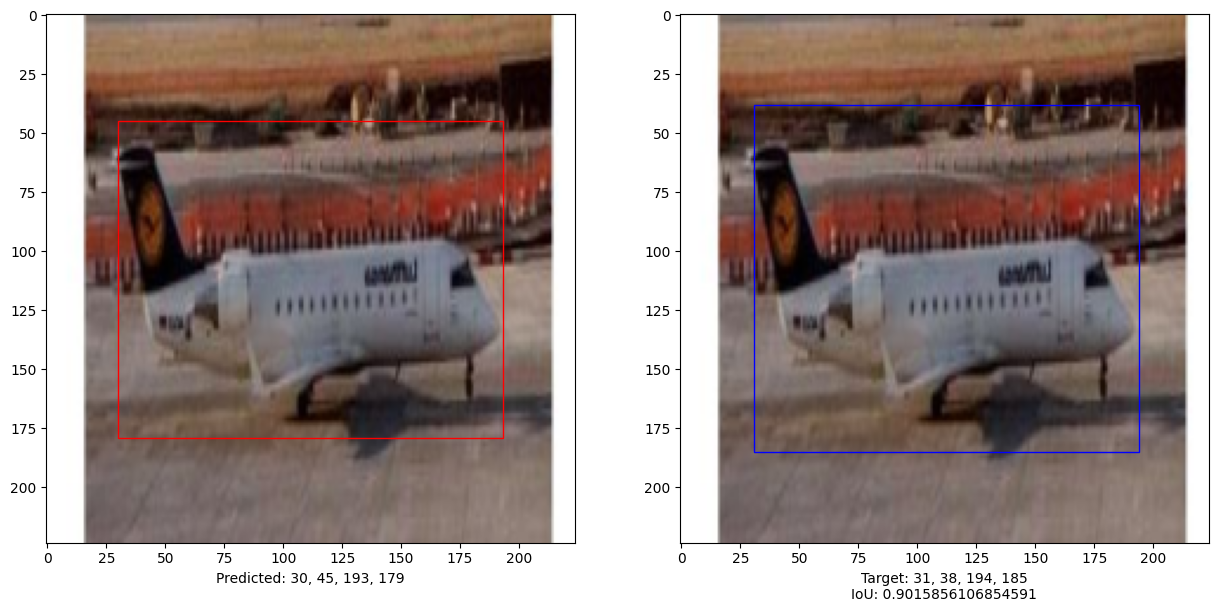

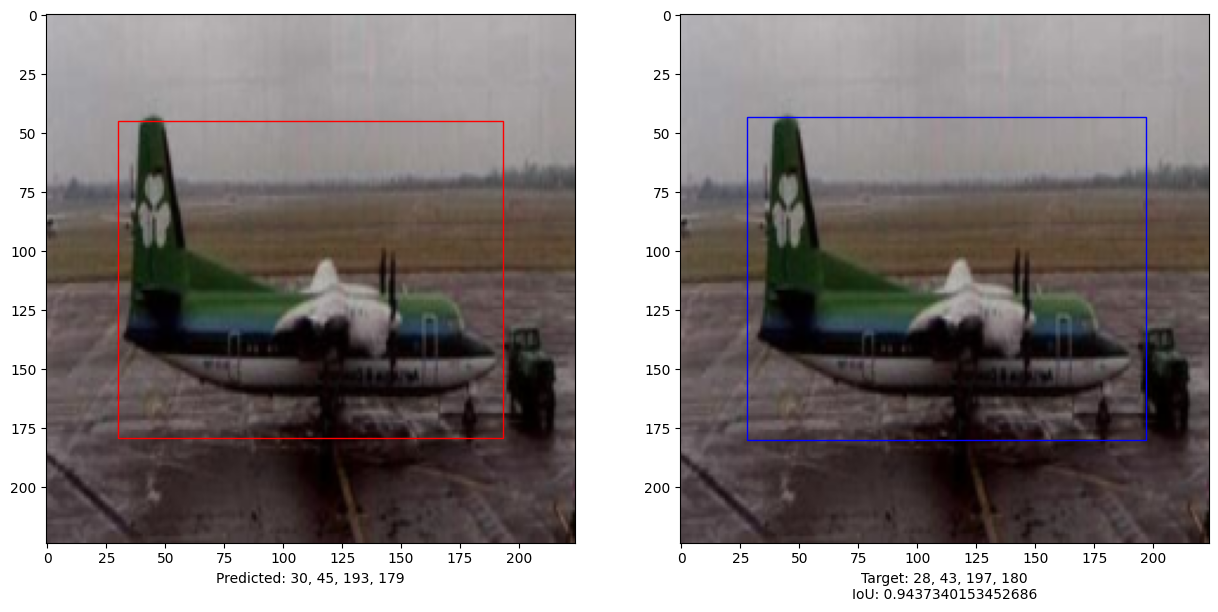

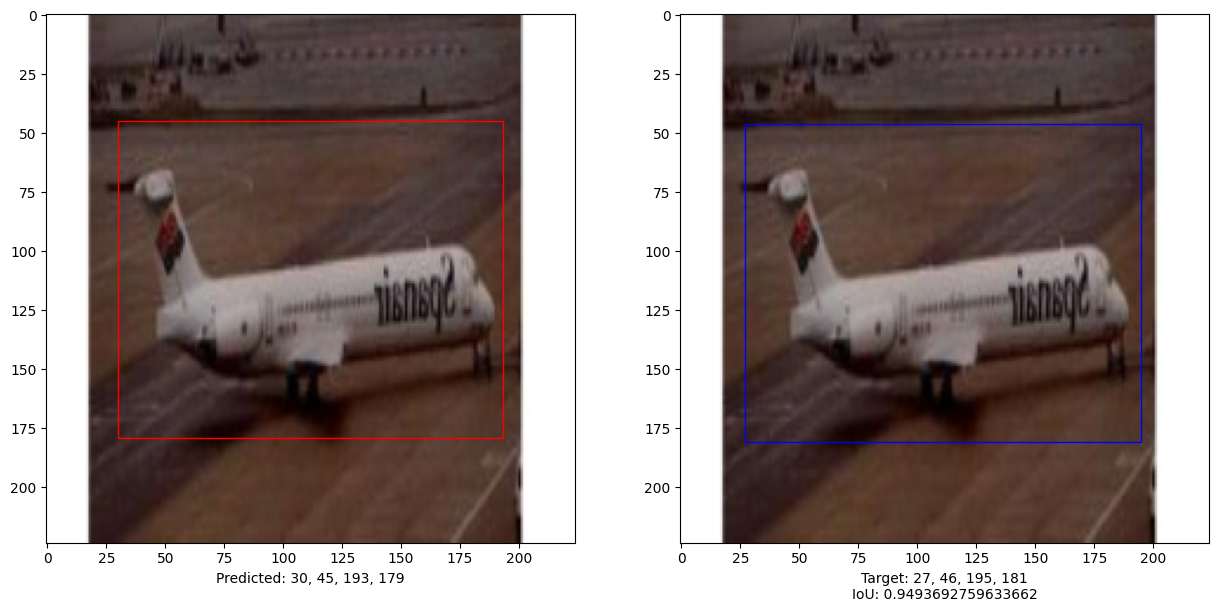

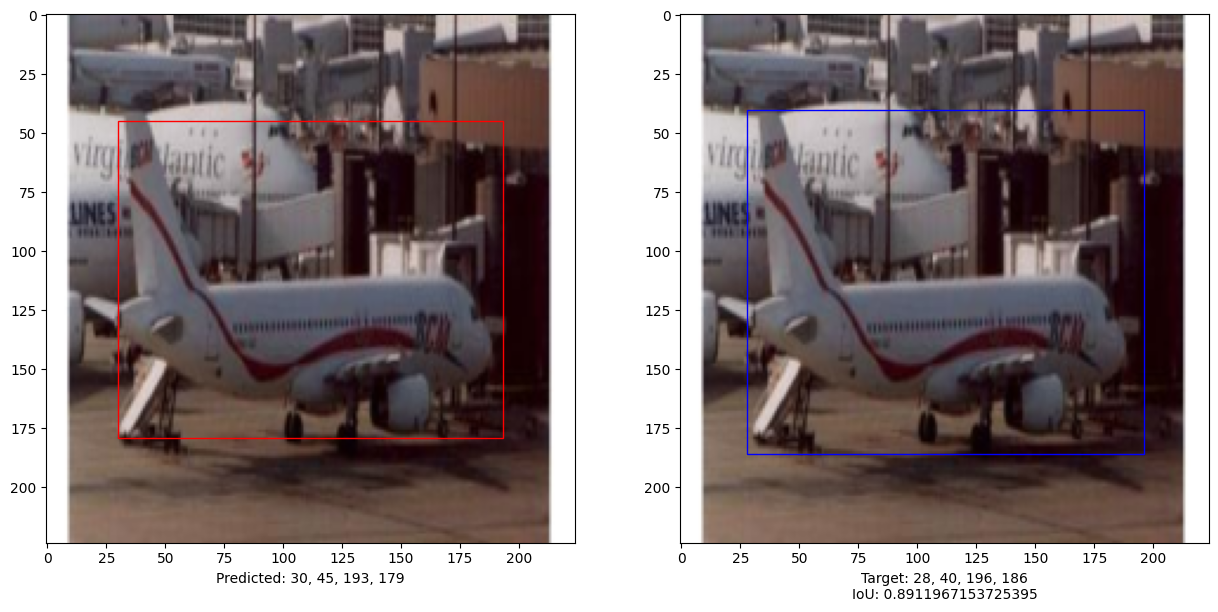

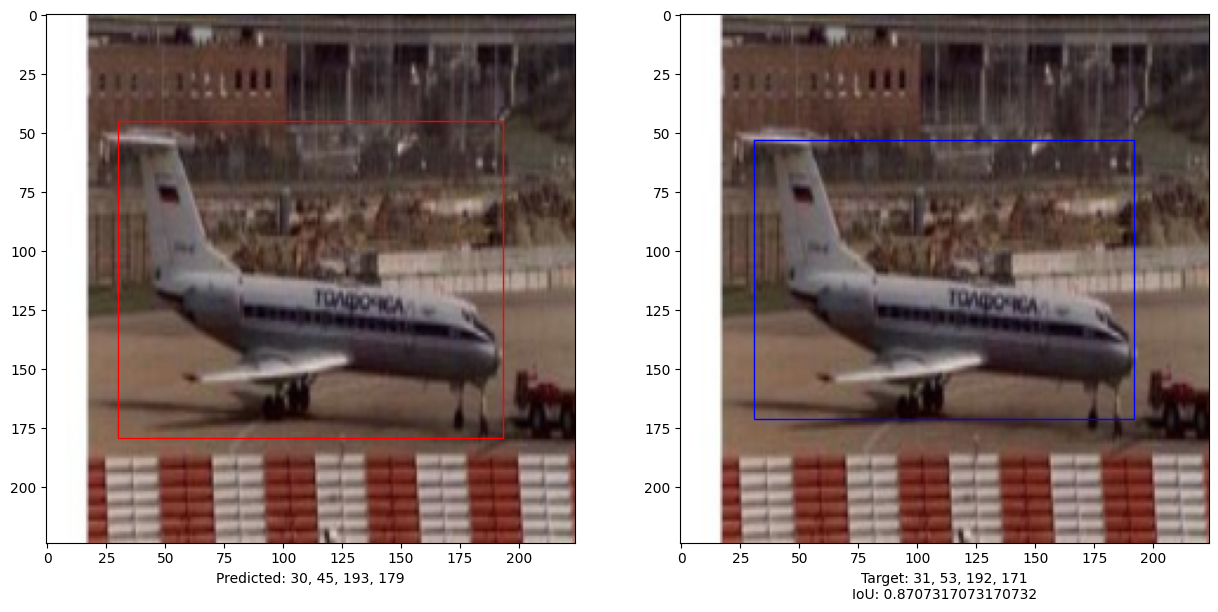

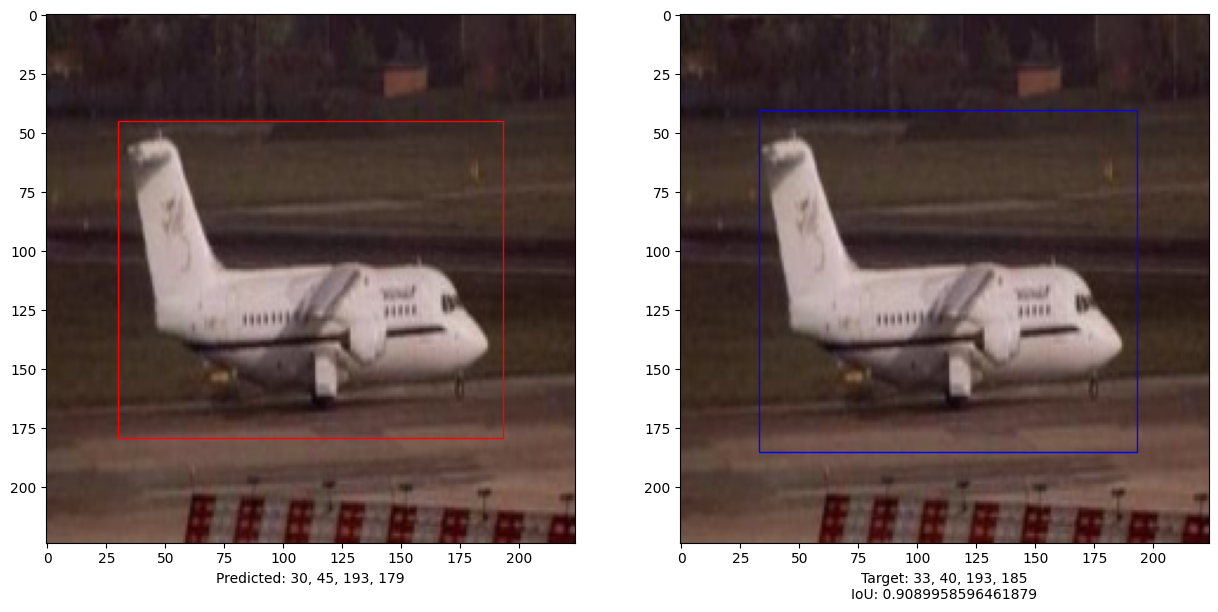

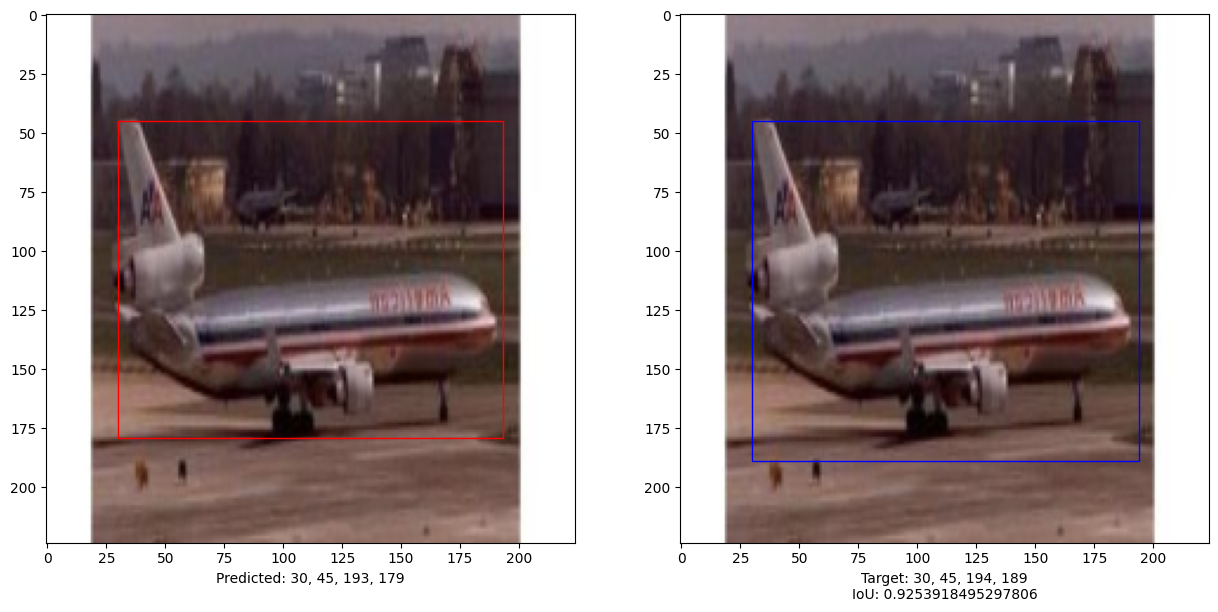

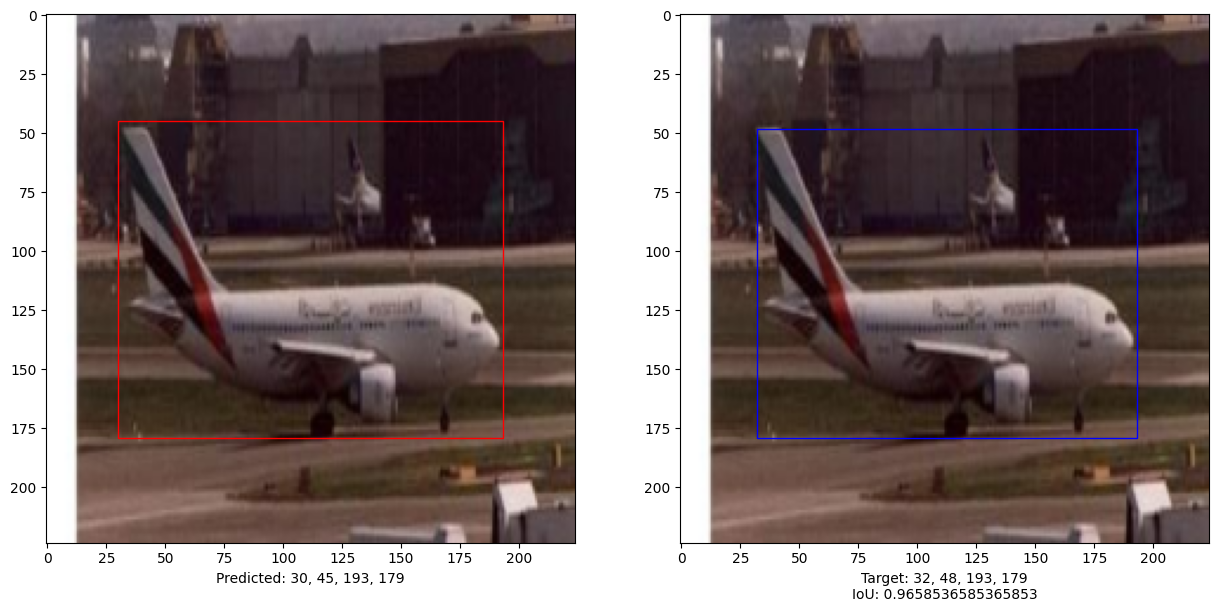

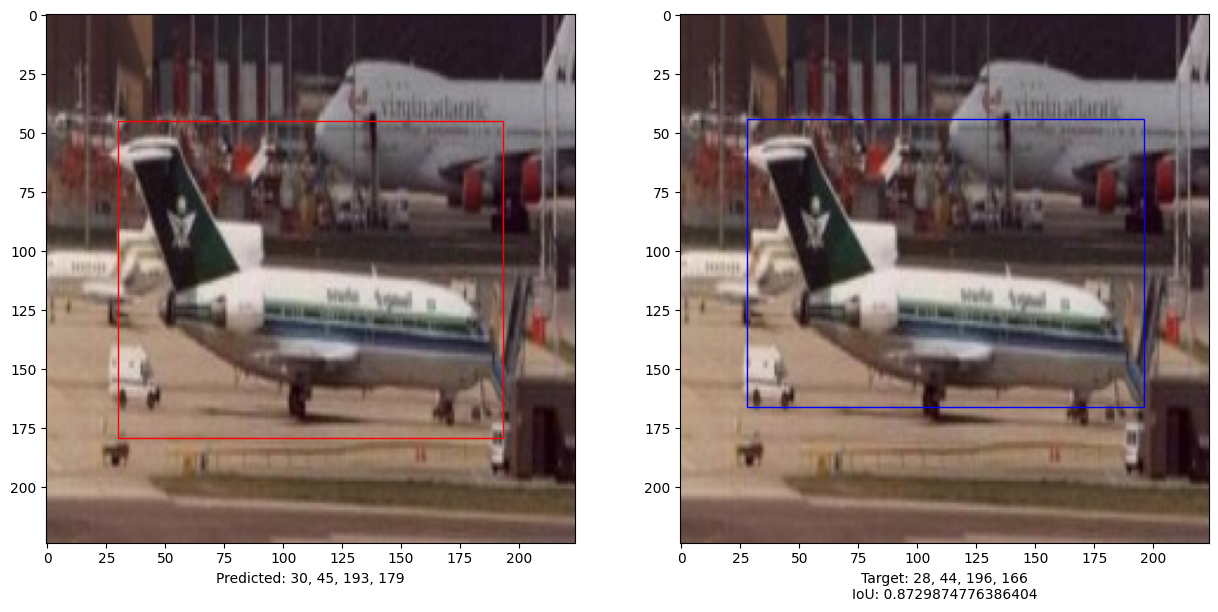

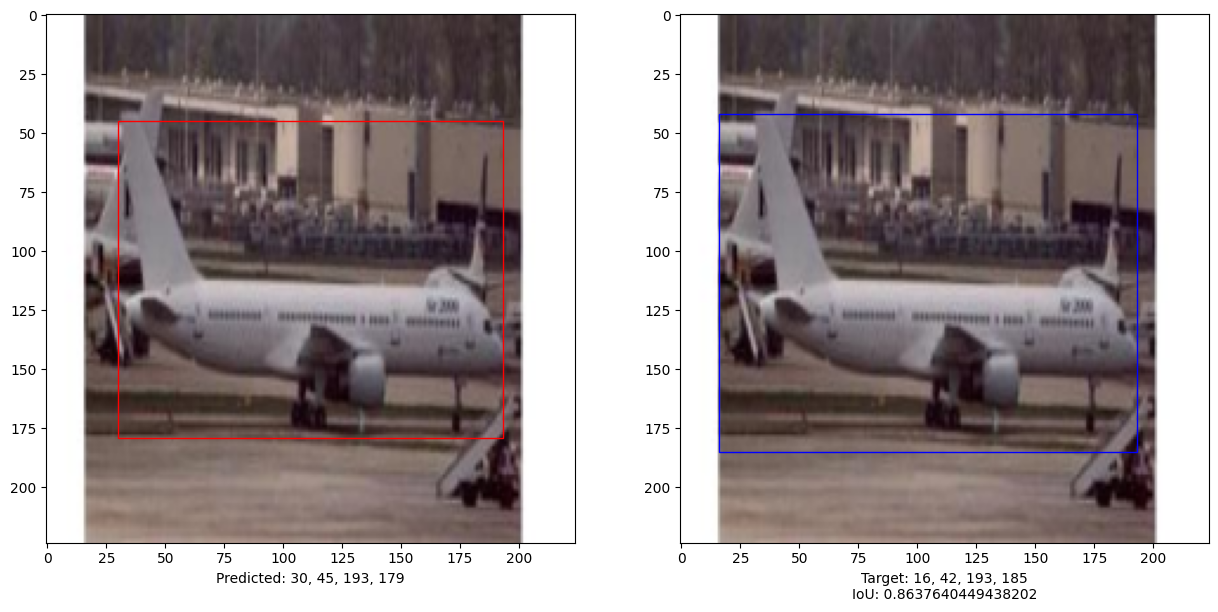

In [37]:

def bounding_box_intersection_over_union(box_pred, box_true):
    xA = max(box_pred[0], box_true[0])
    yA = max(box_pred[1], box_true[1])
    xB = min(box_pred[2], box_true[2])
    yB = min(box_pred[3], box_true[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxPredArea = (box_pred[2] - box_pred[0] + 1) * (box_pred[3] - box_pred[1] + 1)
    boxTrueArea = (box_true[2] - box_true[0] + 1) * (box_true[3] - box_true[1] + 1)
    
    iou = interArea / float(boxPredArea + boxTrueArea - interArea)
    return iou

i, mean_iou = 0, 0
for input_image, ground_truth in zip(x_test[:10], y_test[:10]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image
    im = input_image.numpy().transpose(1, 2, 0)
    ax1.imshow(im)
    ax2.imshow(im)

    input_image_np = input_image.numpy().transpose(1, 2, 0)
    input_image_resized = cv2.resize(input_image_np, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image_tensor = torch.tensor(input_image_resized, dtype=torch.float32).permute(2, 0, 1)
    input_image_tensor = input_image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():  
        preds = model(input_image_tensor).squeeze().cpu().numpy()  

    (h, w) = im.shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(ground_truth[0] * w), int(ground_truth[1] * h)
    bottom_right_x, bottom_right_y = int(ground_truth[2] * w), int(ground_truth[3] * h)

    box_truth = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="blue",
        linewidth=1,
    )
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU: "
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i += 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()
